In [8]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%run Functions.py

In [3]:
train = pd.read_csv('data/train_c.csv')
test = pd.read_csv('data/test_c.csv')

In [4]:
train ,test = get_additional_features(train,test,magic=False)

# BOX_COX Transformation?

In [16]:
from scipy import stats
import scipy

In [67]:
label = train['y']
box_cox_label = stats.boxcox(label,-2)
box_cox_label = box_cox_label

In [80]:
box_cox_label.tolist()

[0.4999707794683758,
 0.49993620464244176,
 0.4999140241649872,
 0.4999230720044192,
 0.49991785935431804,
 0.499942102724149,
 0.4999698416158872,
 0.49994081052714606,
 0.4999576600178866,
 0.49996899505552367,
 0.4999520262578329,
 0.4999480656231153,
 0.49992675135030956,
 0.4999435575096598,
 0.4999491390383565,
 0.49994297737652504,
 0.49995558402126283,
 0.4999616142200091,
 0.4999380101462761,
 0.499939367894046,
 0.49993903266990475,
 0.4999440933813172,
 0.49995724397977276,
 0.4999657191271138,
 0.4999305345769978,
 0.49994291643213407,
 0.49995383435632246,
 0.4999373982478946,
 0.4999383811981613,
 0.4999695728196091,
 0.49991345767884043,
 0.49995702170599826,
 0.4999562217511547,
 0.4999545186722454,
 0.49996204774690983,
 0.4999403571433343,
 0.4999481079407969,
 0.4999636671107733,
 0.49991988463387277,
 0.4999592428216175,
 0.49995140948262995,
 0.4999409005833869,
 0.49994802325364784,
 0.4999741957325935,
 0.49993150678926623,
 0.499959065616703,
 0.4999402004976849

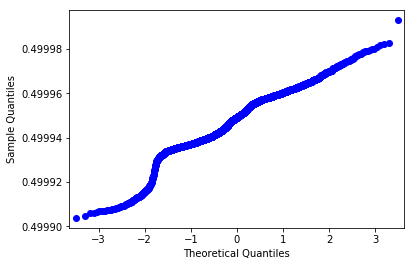

In [69]:
import statsmodels.api as sm
fig2 = sm.qqplot(box_cox_label)
plt.show(fig2)

In [70]:
reverse = scipy.special.inv_boxcox(box_cox_label,-2)

array([ 130.81,   88.53,   76.26, ...,  109.22,   87.48,  110.85])

## Same features, same models, simple testing

In [71]:
y_mean = np.mean(train.y)
xgb_params = {
    'n_trees': 520, 
    'eta': 0.0045,
    'max_depth': 4,
    'subsample': 0.93,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

In [73]:
dtrain = xgb.DMatrix(train.drop('y', axis=1), train.y)
dtest = xgb.DMatrix(test)
num_boost_rounds = 1250

In [75]:
col = test.columns

In [ ]:
(params,rounds,train,col,label,test)

In [77]:
tt_train,tt_test,ID = get_xgb_stack_data(xgb_params,1250,train,col,train.y,test)

Training 1 Fold
R2 Scored of Fold 1 is -3.3464824776
RMSE of Fold 1 is 25.7623245462
Training 2 Fold
R2 Scored of Fold 2 is 0.432627126113
RMSE of Fold 2 is 10.7596189373
Training 3 Fold
R2 Scored of Fold 3 is 0.584368134593
RMSE of Fold 3 is 7.9592853322
Training 4 Fold
R2 Scored of Fold 4 is 0.523965981455
RMSE of Fold 4 is 8.68857665912
Training 5 Fold
R2 Scored of Fold 5 is 0.34575686271
RMSE of Fold 5 is 9.29199725219
Start Training
Calculating In-Bag R2 Score
0.630841792813
Calculating Out-Bag R2 Score
-0.291952874547
Calculating In-Bag RMSE
7.70287317944
Calculating Out-Bag RMSE
12.4923605454


In [87]:
tt_test.to_csv('subStackThenAveragedXGB.csv',index=False)

## Box_Cox Transformation on Label

In [85]:
train['boxcox'] = stats.boxcox(train.y,0).tolist()

In [86]:
tt_train2,tt_test2,ID = get_xgb_stack_data(xgb_params,1250,train,col,train.boxcox,test)

Training 1 Fold
R2 Scored of Fold 1 is -11.8659420215
RMSE of Fold 1 is 0.429520255589
Training 2 Fold
R2 Scored of Fold 2 is -6.1678915524
RMSE of Fold 2 is 0.346521497318
Training 3 Fold
R2 Scored of Fold 3 is -7.32833674992
RMSE of Fold 3 is 0.349092899929
Training 4 Fold
R2 Scored of Fold 4 is -7.24324184093
RMSE of Fold 4 is 0.348396920322
Training 5 Fold
R2 Scored of Fold 5 is -10.1086854135
RMSE of Fold 5 is 0.38297658089
Start Training
Calculating In-Bag R2 Score
-7.67596167218
Calculating Out-Bag R2 Score
-8.54281951565
Calculating In-Bag RMSE
0.358316334147
Calculating Out-Bag RMSE
0.371301630809


In [88]:
dtrain = xgb.DMatrix(train[col],train.boxcox)

In [90]:
model = xgb.train(xgb_params,dtrain,num_boost_round=1250)

In [91]:
Inbag = model.predict(dtrain)

In [92]:
Inbag_actual = np.exp(Inbag)

In [93]:
r2_score(train.y,Inbag_actual)

-9.7174718635901485

In [97]:
pred = model.predict(dtest)

In [99]:
pred = np.exp(pred)

In [101]:
sub = pd.DataFrame({'ID':test['ID'],'y':pred})

In [102]:
sub.to_csv('Test_log_label.csv',index=False)